# Лабораторная работа №5
Пресняцкий Виктор, гр. 956241, вариант 5

## Классификация изображений. Сверточные сети. Полносвязные сети с предобучением.

Дан набор данных изображений цветов, состоящий из 5 классов, разнесенных по отдельным папкам (прилагается в архиве). Сформировать обучающую и валидационную выборки из изображений исходного набора. Преобразовать исходные изображения, имеющие разную размерность матрицы, к одной размерности. 


In [ ]:
import pathlib
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/'My Drive'/'Colab Notebooks'/NSM/Flowers.zip

In [ ]:
!ls Flowers

daisy  dandelion  roses  sunflowers  tulips


Загружаем данные и готовим обучающую и валидационную выборки.

In [ ]:
ALL_PATHS, LABELS, LABELS_MAP = [], [], []
for i, dir in enumerate(pathlib.Path('./Flowers/').glob('*')):
    label = i
    LABELS_MAP.append(dir.name)
    for filename in pathlib.Path(dir).glob('*'):
        ALL_PATHS.append(str(filename))
        LABELS.append(label)

print(f'All images number: {len(ALL_PATHS)}')

All images number: 3165


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(ALL_PATHS, LABELS, test_size=0.25)
total_train = len(train_paths)
total_valid = len(valid_paths)
print(f'Train items number: {total_train}')
print(f'Valid items number: {total_valid}')

Train items number: 2373
Valid items number: 792


In [ ]:
def load_files_to_dirs(paths, labels, folder):
    path = pathlib.Path(folder)
    if path.is_dir():
        shutil.rmtree(str(path))

    for i in set(labels):
        path = pathlib.Path(f'{folder}/{i}/')
        path.mkdir(parents=True, exist_ok=True)

    for i, p in enumerate(paths):
        src = pathlib.Path(p)
        dst = pathlib.Path(f'{folder}/{labels[i]}/{src.name}')
        shutil.copyfile(str(src), str(dst))

In [ ]:
TRAIN_DATA_DIR = 'train_set'
VALID_DATA_DIR = 'valid_set'

In [ ]:
load_files_to_dirs(train_paths, train_labels, folder=TRAIN_DATA_DIR)
load_files_to_dirs(valid_paths, valid_labels, folder=VALID_DATA_DIR)

In [ ]:
BATCH_SIZE = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
def create_generator(directory, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image_gen = ImageDataGenerator(rescale=1./255)
    data_gen = image_gen.flow_from_directory(
        batch_size=batch_size,
        directory=directory,
        target_size=target_size,
        class_mode='categorical',
    )
    return data_gen

Для увеличения количества данных будем использовать аугментацию данных.

In [ ]:
def create_augmented_generator(directory, batch_size=BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    image_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=.15,
        height_shift_range=.15,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
        zoom_range=0.2
    )
    data_gen = image_gen.flow_from_directory(
        batch_size=batch_size,
        directory=directory,
        target_size=target_size,
        class_mode='categorical',
    )
    return data_gen

In [ ]:
def load_images_as_array():
    X = [keras.preprocessing.image.load_img(filename, target_size=(150, 150)) for filename in ALL_PATHS]
    X = np.array([keras.preprocessing.image.img_to_array(img) / 255 for img in X])
    return X

In [ ]:
train_data_gen = create_augmented_generator(TRAIN_DATA_DIR)
valid_data_gen = create_generator(VALID_DATA_DIR)

Found 2373 images belonging to 5 classes.
Found 792 images belonging to 5 classes.


In [ ]:
def show_images(data_gen):
    image_batch, label_batch = next(data_gen)
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(image_batch[n, :, :, :])
        plt.title(LABELS_MAP[label_batch[n].argmax()])
        plt.axis('off')

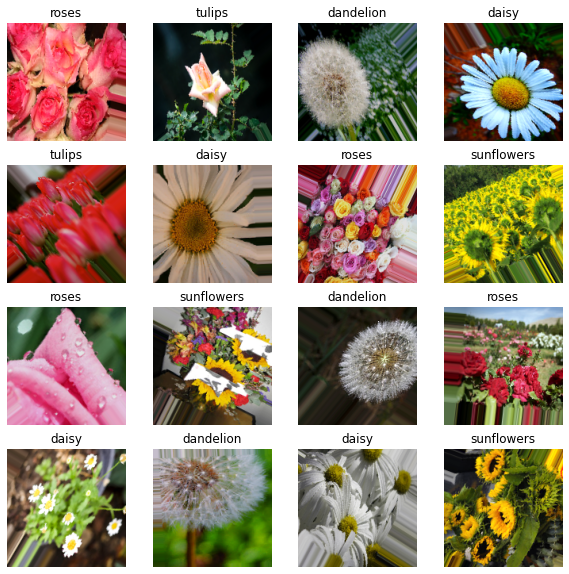

In [ ]:
show_images(train_data_gen)

1. Построить полносвязную нейронную сеть, позволяющую классифицировать на 5 классов исходный набор данных изображений цветов. Пример см. в лекциях. Для улучшения точности обучения и валидации использовать метод преобучения без учителя с применением автокодировщика или ограниченной машины Больцмана (на выбор).  
Выполнить обучение построенной сети для решения задачи классификации изображений цветов из данного набора по 5 классам с одновременной валидацией. Выполнить при этом оценки точности обучения и валидации, а также ошибки потерь. Построить соответствующие графики.

In [ ]:
def build_conv_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.1),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
conv_model = build_conv_model()
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)       

In [ ]:
EPOCHS = 20

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

history = conv_model.fit(
    train_data_gen, 
    epochs=EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    callbacks=[lr_reduction]
)


Epoch 1/20
74/74 [==============================] - 35s 439ms/step - loss: 1.8733 - accuracy: 0.4326 - val_loss: 4.8242 - val_accuracy: 0.2096
Epoch 2/20
74/74 [==============================] - 33s 433ms/step - loss: 1.0880 - accuracy: 0.5783 - val_loss: 5.4986 - val_accuracy: 0.2109
Epoch 3/20
74/74 [==============================] - 33s 433ms/step - loss: 1.0141 - accuracy: 0.6118 - val_loss: 4.0230 - val_accuracy: 0.2188
Epoch 4/20
74/74 [==============================] - 33s 435ms/step - loss: 1.0055 - accuracy: 0.6236 - val_loss: 2.5756 - val_accuracy: 0.2812
Epoch 5/20
74/74 [==============================] - 33s 432ms/step - loss: 0.9113 - accuracy: 0.6444 - val_loss: 1.3549 - val_accuracy: 0.4857
Epoch 6/20
74/74 [==============================] - 34s 437ms/step - loss: 0.8339 - accuracy: 0.6837 - val_loss: 1.3780 - val_accuracy: 0.5026
Epoch 7/20
74/74 [==============================] - 33s 435ms/step - loss: 0.7864 - accuracy: 0.6938 - val_loss: 0.8307 - val_accuracy: 0.7018

In [ ]:
def show_history(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

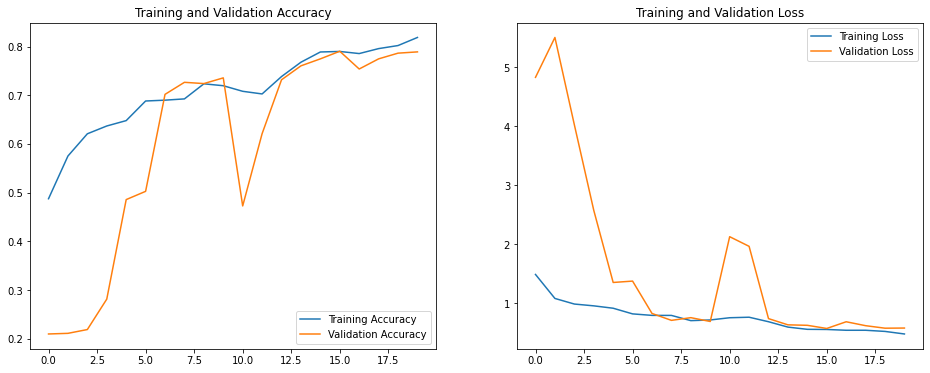

In [ ]:
show_history(history)

2. Построить полносвязную нейронную сеть, позволяющую классифицировать на 5 классов исходный набор данных изображений цветов. Пример см. в лекциях. Для улучшения точности обучения и валидации использовать метод преобучения без учителя с применением автокодировщика или ограниченной машины Больцмана (на выбор).  
Выполнить обучение построенной сети для решения задачи классификации изображений цветов из данного набора по 5 классам с одновременной валидацией. Выполнить при этом оценки точности обучения и валидации, а также ошибки потерь. Построить соответствующие графики.

In [ ]:
X_train = load_images_as_array()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_train.shape

(3165, 67500)

In [ ]:
def build_auto_encoder_layers(X):
    verbose = 0
    lr_reduction = ReduceLROnPlateau(
        monitor='loss',
        patience=3, 
        verbose=verbose, 
        factor=0.3, 
        min_lr=1e-5
    )

    neurons_on_layers = [IMG_WIDTH * IMG_HEIGHT * 3, 256, 128, 64, 32]

    auto_encoder_layers = []
    cur_X = X

    for i in range(len(neurons_on_layers) - 1):
        input_layer = neurons_on_layers[i]
        output_layer = neurons_on_layers[i + 1]
        auto_encoder = keras.models.Sequential([
            keras.layers.Dense(output_layer, activation='tanh', bias_regularizer='l2'),
            keras.layers.Dense(input_layer, activation='linear', bias_regularizer='l2'),
        ])
        auto_encoder.compile(loss='mean_squared_error', optimizer='adam')
        auto_encoder.fit(cur_X, cur_X, epochs=50, callbacks=[lr_reduction], verbose=verbose)

        cur_model = keras.models.Sequential()
        cur_layer = auto_encoder.layers.pop(0)
        cur_model.add(cur_layer)
        cur_X = cur_model.predict(cur_X)
        cur_X = cur_X / cur_X.sum(axis=1)[:, np.newaxis]
        auto_encoder_layers.append(cur_layer)
        print(f'{i + 1} layer generated')

    return auto_encoder_layers


def build_ae_dense_model(auto_encoder_layers):
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', weights=auto_encoder_layers[0].get_weights()),
        keras.layers.Dense(128, activation='relu', weights=auto_encoder_layers[1].get_weights()),
        keras.layers.Dense(64, activation='relu', weights=auto_encoder_layers[2].get_weights()),
        keras.layers.Dense(32, activation='relu', weights=auto_encoder_layers[3].get_weights()),
        keras.layers.Dense(5, activation='softmax'),
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
auto_encoder_layers = build_auto_encoder_layers(X_train)
ae_dense_model = build_ae_dense_model(auto_encoder_layers)

1 layer generated
2 layer generated
3 layer generated
4 layer generated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
FINE_TUNING_EPOCHS = 30

history = ae_dense_model.fit(
    train_data_gen, 
    epochs=FINE_TUNING_EPOCHS,
    workers=4,
    validation_data=valid_data_gen,
    validation_steps=total_valid // BATCH_SIZE,
    steps_per_epoch=total_train * 2 // BATCH_SIZE,
    callbacks=[lr_reduction]
)


Epoch 1/30
74/74 [==============================] - 34s 434ms/step - loss: 22.7956 - accuracy: 0.2996 - val_loss: 6.7076 - val_accuracy: 0.2969
Epoch 2/30
74/74 [==============================] - 33s 431ms/step - loss: 5.9868 - accuracy: 0.3423 - val_loss: 2.1912 - val_accuracy: 0.3529
Epoch 3/30
74/74 [==============================] - 33s 432ms/step - loss: 3.2882 - accuracy: 0.3831 - val_loss: 1.8105 - val_accuracy: 0.3802
Epoch 4/30
74/74 [==============================] - 34s 435ms/step - loss: 2.4467 - accuracy: 0.3716 - val_loss: 1.7550 - val_accuracy: 0.4284
Epoch 5/30
74/74 [==============================] - 33s 435ms/step - loss: 2.0245 - accuracy: 0.3873 - val_loss: 1.7987 - val_accuracy: 0.4102
Epoch 6/30
74/74 [==============================] - 33s 431ms/step - loss: 1.7951 - accuracy: 0.4015 - val_loss: 1.5428 - val_accuracy: 0.4258
Epoch 7/30
74/74 [==============================] - 33s 431ms/step - loss: 1.5983 - accuracy: 0.4073 - val_loss: 1.4871 - val_accuracy: 0.438

Как можно заметить, accuracy постепенно растёт. Это значит, что можно увеличить количество эпох, например до 100, и тогда точность сети станет ещё больше.

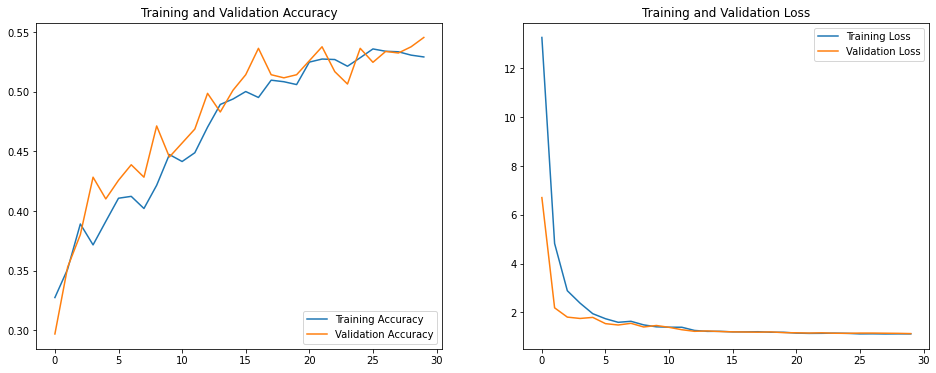

In [ ]:
show_history(history)

3. Сравнить полученные точности для построенных сверточной и полносвязной сетей.

In [ ]:
conv_accuracy = conv_model.evaluate(valid_data_gen, verbose=0)[1]
ae_dense_accuracy = ae_dense_model.evaluate(valid_data_gen, verbose=0)[1]

print(f'Test accuracy convolution network: {conv_accuracy * 100:.2f}%')
print(f'Test accuracy fully connected network with autoencoder: {ae_dense_accuracy * 100:.2f}%')

Test accuracy convolution network: 78.66%
Test accuracy fully connected network with autoencoder: 54.04%
